# Compare  Gaia DR2 and EDR3 catalogs in the area of SDSS Stripe82 catalog  

In [1]:
%matplotlib inline
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import hstack
import matplotlib.pyplot as plt 
import numpy as np
from astroML.plotting import hist
# for astroML installation see https://www.astroml.org/user_guide/installation.html

In [2]:
## automatically reload any modules read below that might have changed (e.g. plots)
%load_ext autoreload
%autoreload 2
# importing ZI tools: 
import ZItools as zit
# importing Karun's tools: 
import KTtools as ktt

<a id='dataTools'></a>

### Helper Tools

In [14]:
# both new and old files use identical data structure
colnamesSDSS = ['calib_fla', 'ra', 'dec', 'raRMS', 'decRMS', 'nEpochs', 'AR_val', 
                'u_Nobs', 'u_mMed', 'u_mMean', 'u_mErr', 'u_rms_scatt', 'u_chi2',
                'g_Nobs', 'g_mMed', 'g_mMean', 'g_mErr', 'g_rms_scatt', 'g_chi2',
                'r_Nobs', 'r_mMed', 'r_mMean', 'r_mErr', 'r_rms_scatt', 'r_chi2',
                'i_Nobs', 'i_mMed', 'i_mMean', 'i_mErr', 'i_rms_scatt', 'i_chi2',
                'z_Nobs', 'z_mMed', 'z_mMean', 'z_mErr', 'z_rms_scatt', 'z_chi2']

### code for generating new quantities, such as dra, ddec, colors, differences in mags, etc
def derivedColumnsGaiaCompare(matches):
    matches['dra'] = (matches['ra_new']-matches['ra_old'])*3600
    matches['ddec'] = (matches['dec_new']-matches['dec_old'])*3600
    ra = matches['ra_new'] 
    matches['raW'] = np.where(ra > 180, ra-360, ra) 
    matches['dGmag'] = matches['Gmag_new'] - matches['Gmag_old']
    matches['dBP'] = matches['BPmag_new'] - matches['BPmag_old']
    matches['dRP'] = matches['RPmag_new'] - matches['RPmag_old']
    matches['Gmag'] = matches['Gmag_new']  
    matches['ra'] = matches['ra_new'] 
    matches['dec'] = matches['dec_new'] 
    return

In [23]:
def doOneBand(d, kw):
    print('=========== WORKING ON:', kw['Ystr'], '===================')
    xVec = d[kw['Xstr']]
    yVec = d[kw['Ystr']]
    goodC = d[np.abs(d[kw['Ystr']])<0.3] 

    ### plots 
    # RA
    print(' stats for RA binning medians:')
    plotNameRoot = kw['plotNameRoot'] + kw['Xstr'] + '_' + kw['Ystr']
    plotName = plotNameRoot + '_RA.png'
    Ylabel = kw['Ystr'] + ' (mag)'
    kwOC = {"Xstr":'raW', "Xmin":-52, "Xmax":60.5, "Xlabel":'R.A. (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-51.5, "XmaxBin":58, "nBin":56, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_RA_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 55
    kwOC["nBinY"] = 25
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)  
    print('made plot', plotName)

    # Dec
    print('-----------')
    print(' stats for Dec binning medians:')
    plotName = plotNameRoot + '_Dec.png'
    kwOC = {"Xstr":'dec', "Xmin":-1.3, "Xmax":1.3, "Xlabel":'Declination (deg)', \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":-1.26, "XmaxBin":1.26, "nBin":52, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_Dec_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 55
    kwOC["nBinY"] = 25
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)

    # vs supplied X 
    print('-----------')
    print(' stats for SDSS r binning medians:')
    plotName = plotNameRoot + '_rmag.png'    
    Xlabel = kw['Xstr'] + ' (mag)'
    kwOC = {"Xstr":kw['Xstr'], "Xmin":14.3, "Xmax":22.2, "Xlabel":Xlabel, \
          "Ystr":kw['Ystr'], "Ymin":-0.07, "Ymax":0.07, "Ylabel":Ylabel, \
          "XminBin":14.5, "XmaxBin":21.5, "nBin":55, \
          "plotName":plotName, "Nsigma":3, "offset":0.01, "symbSize":kw['symbSize']}
    zit.plotdelMag(goodC, kwOC)
    plotName = plotNameRoot + '_' + kw['Xstr'] + '_mag_Hess.png'    
    kwOC["plotName"] = plotName
    kwOC["nBinX"] = 55
    kwOC["nBinY"] = 25
    kwOC["cmap"] = 'plasma'
    ktt.plotdelMagBW_KT(goodC, kwOC)
    print('made plot', plotName)
    print('------------------------------------------------------------------')
    return 

<a id='dataReading'></a>

### Define paths and catalogs 

In [17]:
ZIdataDir = "/Users/ivezic/Work/Science/CalibrationV2/SDSS_SSC/Data"
# Gaia DR2 with BP and RP data
GaiaDR2CatBR = ZIdataDir + "/" + "Stripe82_GaiaDR2_BPRP.dat" 
# Gaia EDR3 with BP and RP data
GaiaEDR3CatBR = ZIdataDir + "/" + "Stripe82_GaiaEDR3_BPRP.dat" 
colnamesGaia = ['ra', 'dec', 'nObs', 'Gmag', 'flux', 'fluxErr', 'pmra', 'pmdec']
colnamesGaia = colnamesGaia + ['BPmag', 'BPeI', 'RPmag', 'RPeI', 'BRef']

In [19]:
gaia2 = Table.read(GaiaDR2CatBR, format='ascii', names=colnamesGaia)
gaia2['raG'] = gaia2['ra']
gaia2['decG'] = gaia2['dec']    
gaia2['BR'] = gaia2['BPmag'] - gaia2['RPmag'] 

In [6]:
gaia3 = Table.read(GaiaEDR3CatBR, format='ascii', names=colnamesGaia)
gaia3['raG'] = gaia3['ra']
gaia3['decG'] = gaia3['dec']    
gaia3['BR'] = gaia3['BPmag'] - gaia3['RPmag'] 

In [20]:
gaia2_coords = SkyCoord(ra = gaia2['ra']*u.degree, dec= gaia2['dec']*u.degree) 
gaia3_coords = SkyCoord(ra = gaia3['ra']*u.degree, dec= gaia3['dec']*u.degree) 
# this is matching sdssNew to sdssOld, so that indices are into sdssNew catalog
# makes sense in this case since the sdssOld catalog is (a little bit) bigger 
# than sdssNew (1006849 vs 1005470)
idx, d2d, d3d = gaia3_coords.match_to_catalog_sky(gaia2_coords)  

gaiaAll = hstack([gaia3, gaia2[idx]], table_names = ['new', 'old'])
gaiaAll['sep_2d_arcsec'] = d2d.arcsec
# good matches between the old and new catalogs
MAX_DISTANCE_ARCSEC = 0.5
gaia = gaiaAll[(gaiaAll['sep_2d_arcsec'] < MAX_DISTANCE_ARCSEC)]
print(np.size(gaiaAll))
print(np.size(gaia))

2526361
2388552


In [59]:
gaiaOK = gaia[(gaia['BPmag_old']>10)&(gaia['BPmag_old']<22)]
gaiaOK2 = gaiaOK[(gaiaOK['BPmag_new']>10)&(gaiaOK['BPmag_new']<22)]
gaiaOK3 = gaiaOK2[(gaiaOK2['RPmag_old']>10)&(gaiaOK2['RPmag_old']<22)]
gaiaOK4 = gaiaOK3[(gaiaOK3['RPmag_new']>10)&(gaiaOK3['RPmag_new']<22)]
print(np.size(gaiaOK4))

2178312


In [64]:
derivedColumnsGaiaCompare(gaiaOK4)

In [60]:
for mag in ('dGmag', 'dBP', 'dRP'):
    med = np.median(gaiaOK4[mag])
    print(mag,': ',med)
    gaiaOK4[mag] = gaiaOK4[mag] - med

dGmag :  -0.027973175048828125
dBP :  -0.004638671875
dRP :  -0.0011844635009765625


=========== WORKING ON: dGmag ===================
 stats for RA binning medians:
medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: -0.0010061264038085938 std.dev: 0.0014141131743618497
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_RA.png


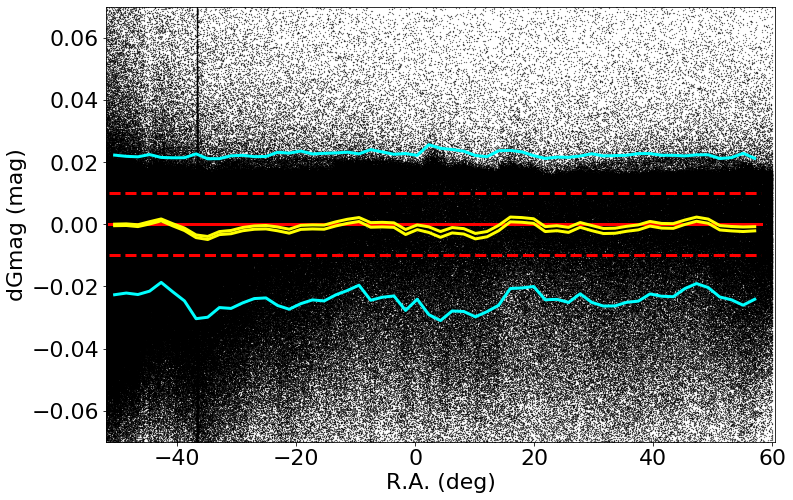

medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: -0.0010318756103515625 std.dev: 0.0014231682778364403
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_RA_Hess.png


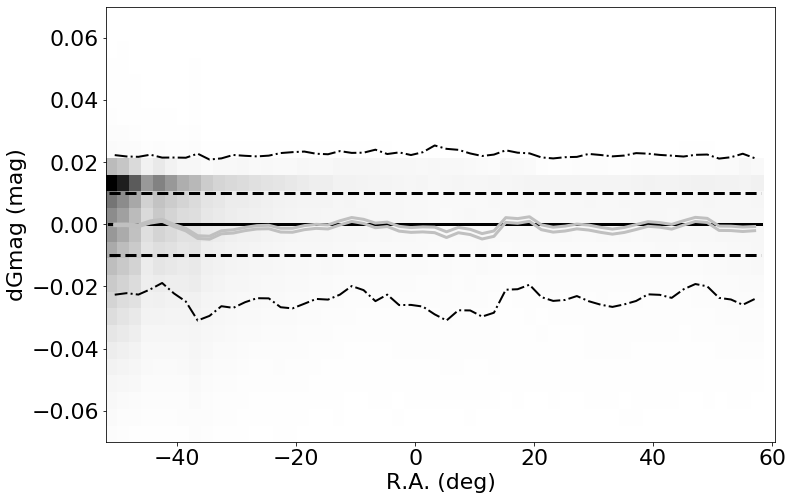

made plot testGaiaDR2vsEDR3_Gmag_dGmag_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: -0.00032901763916015625 std.dev: 0.0002442547809044021
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Dec.png


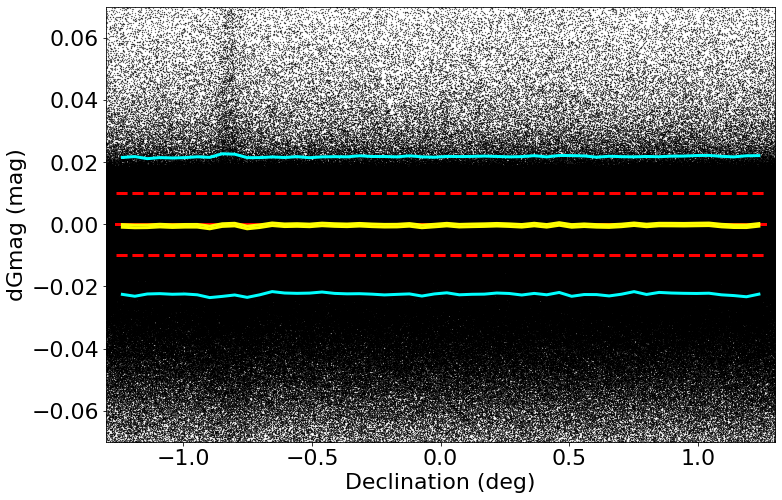

medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: -0.0003147125244140625 std.dev: 0.00025700190947464596
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Dec_Hess.png


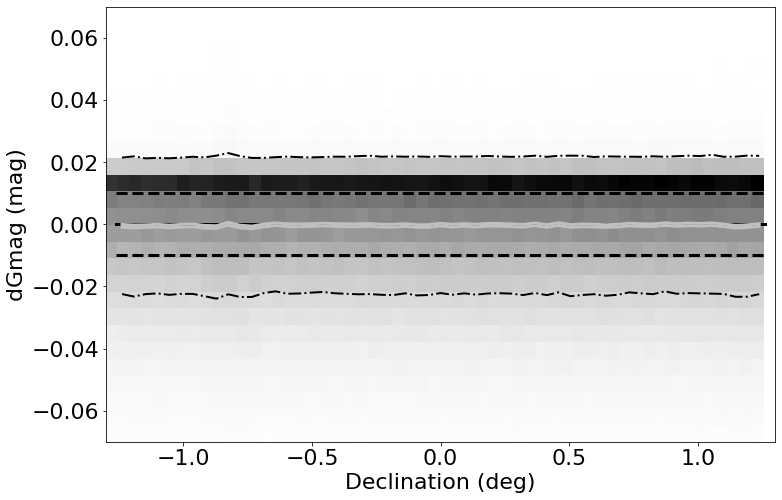

made plot testGaiaDR2vsEDR3_Gmag_dGmag_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: 0.011405467987060547 std.dev: 0.05611589694037321
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_rmag.png


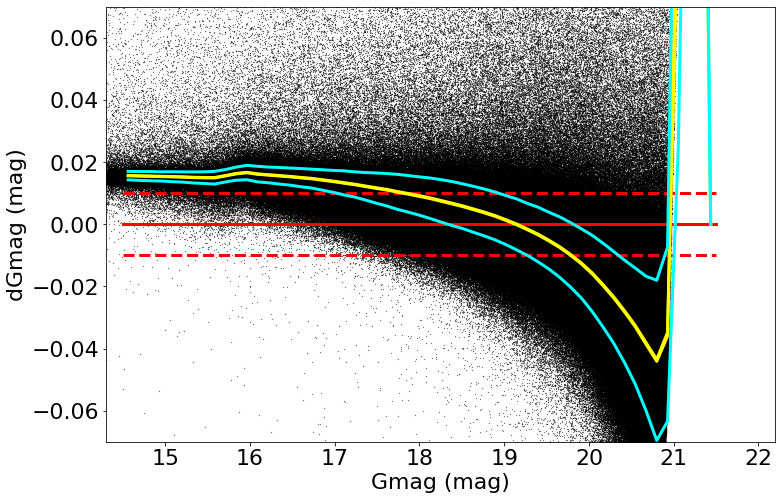

medianAll: -0.000331878662109375 std.dev.All: 0.022159841537475584
N= 2152372 min= -0.29981422424316406 max= 0.2999591827392578
median: 0.011405467987060547 std.dev: 0.05611589694037321
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Gmag_mag_Hess.png


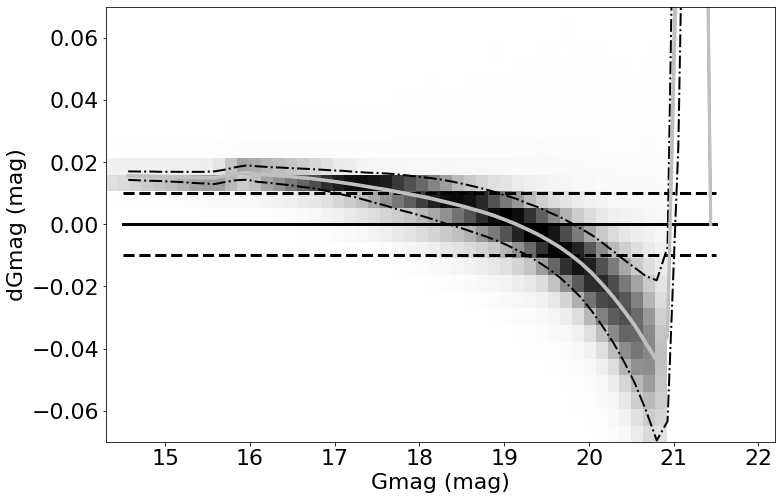

made plot testGaiaDR2vsEDR3_Gmag_dGmag_Gmag_mag_Hess.png
------------------------------------------------------------------


In [61]:
keywords = {"Xstr":'Gmag', "plotNameRoot":'testGaiaDR2vsEDR3_', "symbSize":0.05}
keywords["Ystr"] = 'dGmag'
doOneBand(gaiaOK4, keywords)

=========== WORKING ON: dBP ===================
 stats for RA binning medians:
medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.014162778854370117 std.dev: 0.011756750142134986
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_RA.png


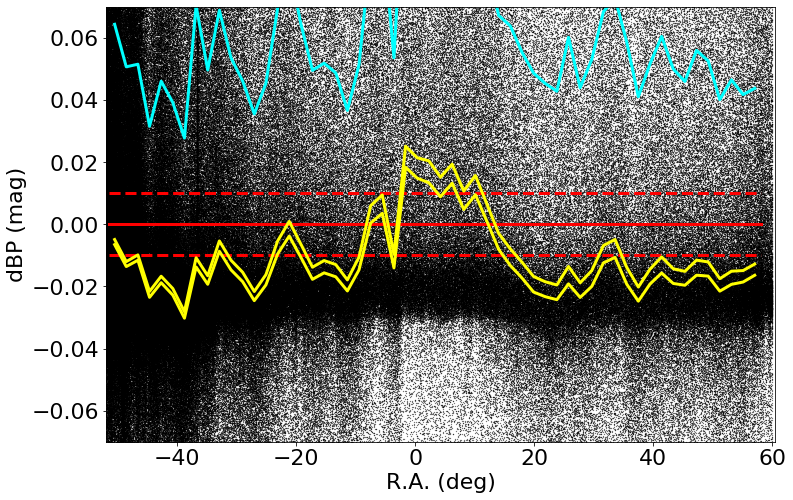

medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.01453399658203125 std.dev: 0.011527534679351732
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_RA_Hess.png


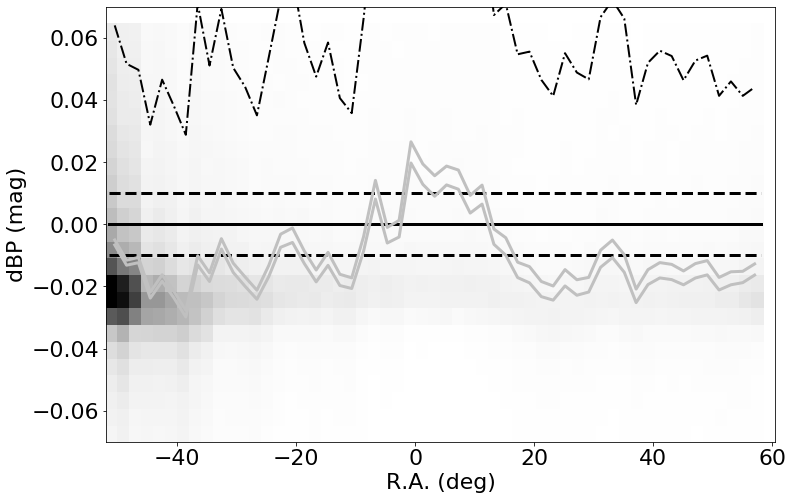

made plot testGaiaDR2vsEDR3_Gmag_dBP_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.009406089782714844 std.dev: 0.0016457430756715073
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Dec.png


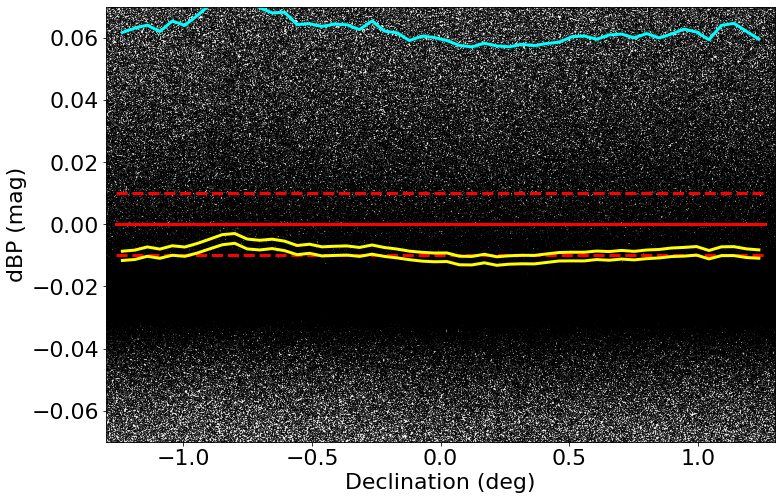

medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.009517669677734375 std.dev: 0.0016528420862280107
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Dec_Hess.png


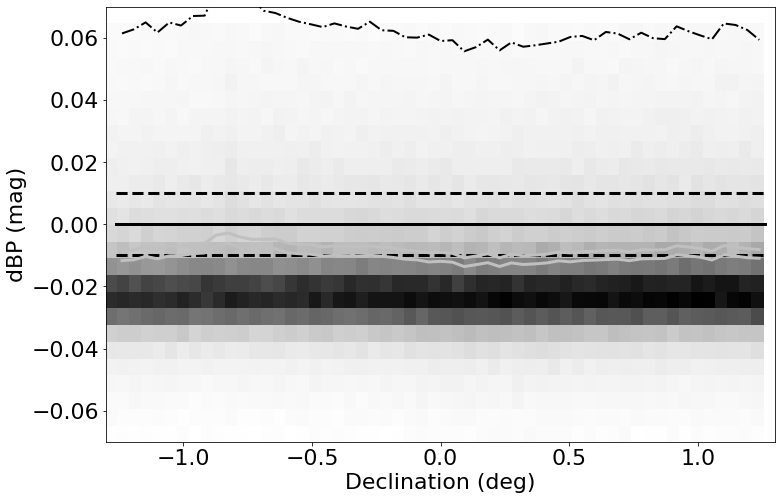

made plot testGaiaDR2vsEDR3_Gmag_dBP_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.009265899658203125 std.dev: 0.03758895088982797
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_rmag.png


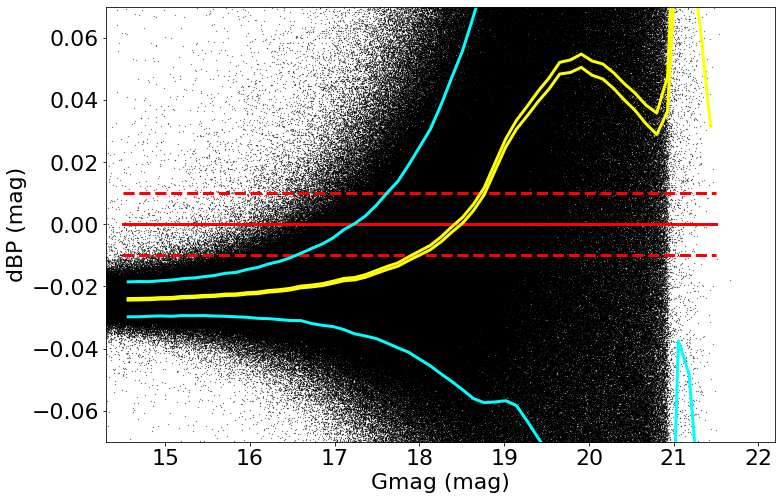

medianAll: -0.009288787841796875 std.dev.All: 0.0717696762084961
N= 1901187 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.009265899658203125 std.dev: 0.03758895088982797
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Gmag_mag_Hess.png


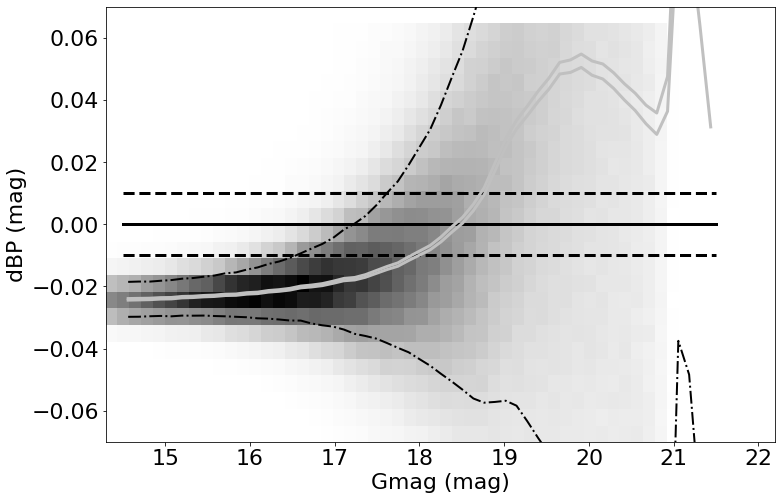

made plot testGaiaDR2vsEDR3_Gmag_dBP_Gmag_mag_Hess.png
------------------------------------------------------------------


In [68]:
keywords = {"Xstr":'Gmag', "plotNameRoot":'testGaiaDR2vsEDR3_', "symbSize":0.05}
keywords["Ystr"] = 'dBP'
doOneBand(gaiaOK4, keywords)

In [66]:
gaiaB = gaiaOK4[(gaiaOK4['Gmag']>14)&(gaiaOK4['Gmag']<19)]
print(np.size(gaiaB)) 

926560


In [65]:
for mag in ('dGmag', 'dBP', 'dRP'):
    med = np.median(gaiaB[mag])
    print(mag,': ',med)
    gaiaB[mag] = gaiaB[mag] - med

926560
dGmag :  -0.016702651977539062
dBP :  -0.017292022705078125
dRP :  -0.007869720458984375


=========== WORKING ON: dGmag ===================
 stats for RA binning medians:
medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.017982006072998047 std.dev: 0.0010461613779150535
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_RA.png


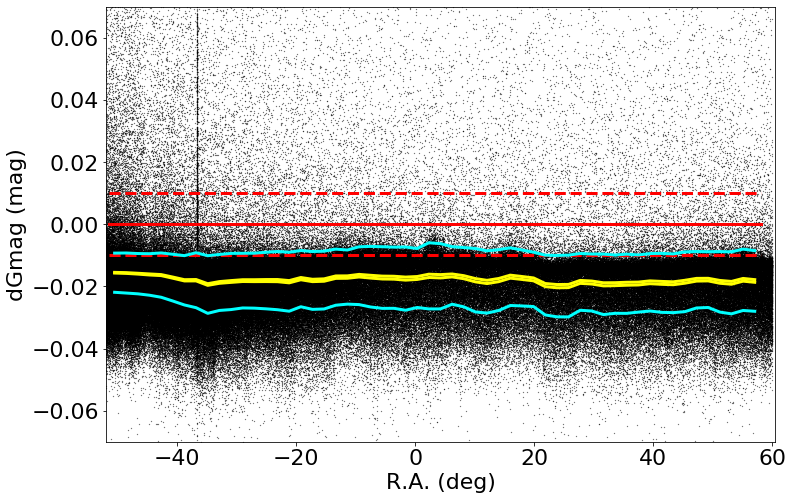

medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.017999649047851562 std.dev: 0.0010459163139545952
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_RA_Hess.png


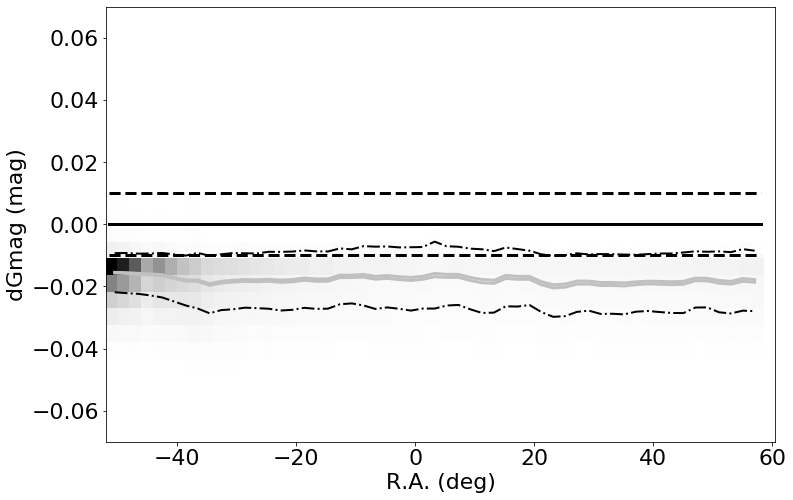

made plot testGaiaDR2vsEDR3_Gmag_dGmag_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.0167233943939209 std.dev: 0.00013640730221451807
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Dec.png


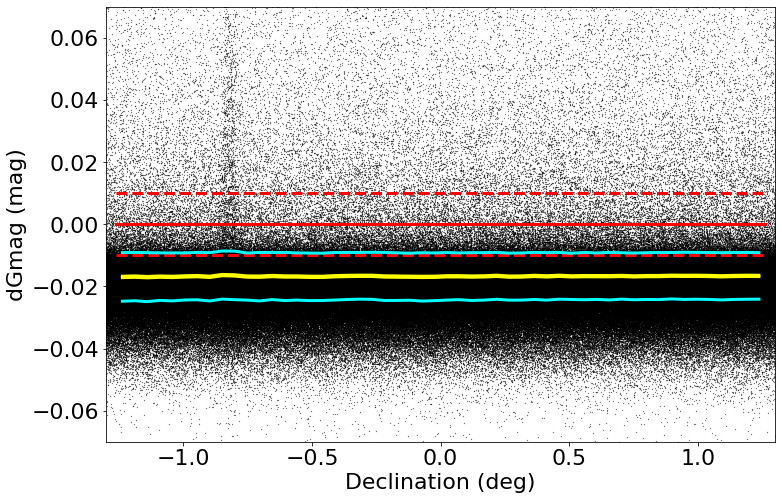

medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.016719818115234375 std.dev: 0.0001431081737001288
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Dec_Hess.png


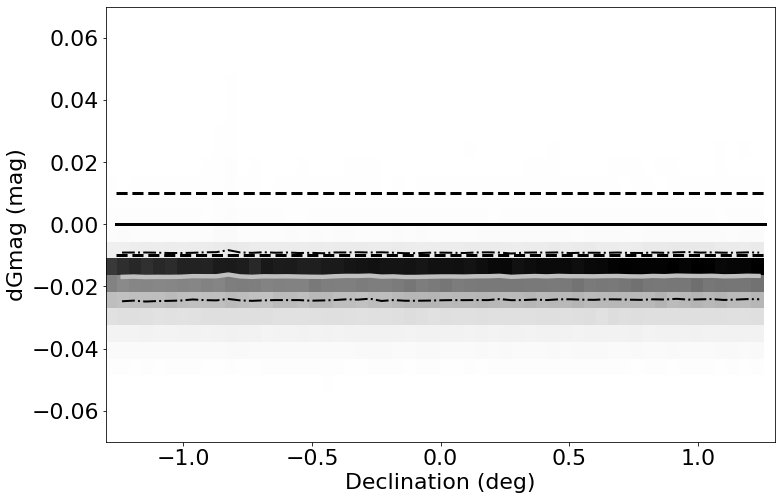

made plot testGaiaDR2vsEDR3_Gmag_dGmag_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.013458251953125 std.dev: 0.00427465677178019
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_rmag.png


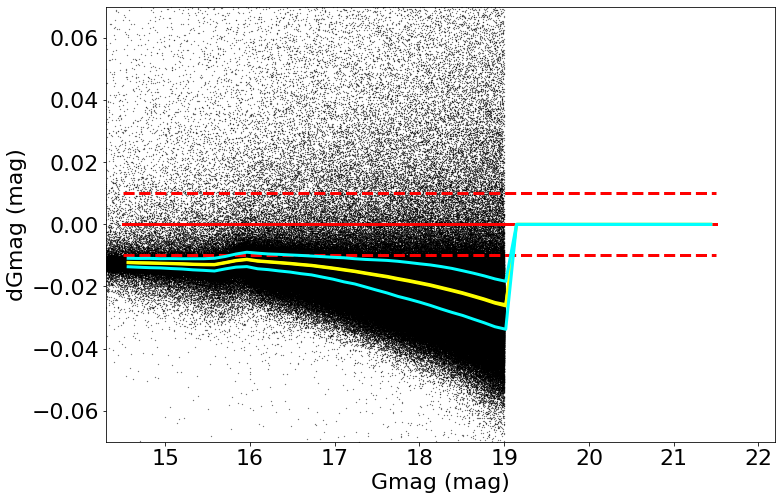

medianAll: -0.01671600341796875 std.dev.All: 0.007615811347961425
N= 925279 min= -0.29749298095703125 max= 0.29988574981689453
median: -0.013458251953125 std.dev: 0.00427465677178019
saved plot as: testGaiaDR2vsEDR3_Gmag_dGmag_Gmag_mag_Hess.png


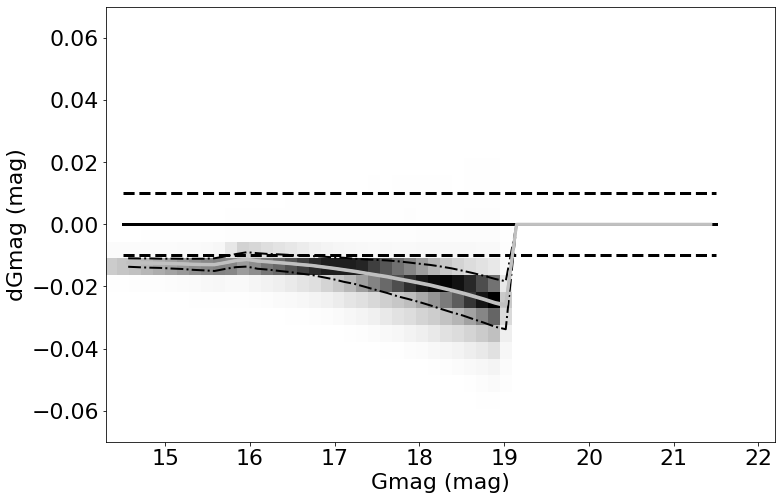

made plot testGaiaDR2vsEDR3_Gmag_dGmag_Gmag_mag_Hess.png
------------------------------------------------------------------


In [67]:
keywords = {"Xstr":'Gmag', "plotNameRoot":'testGaiaDR2vsEDR3_', "symbSize":0.05}
keywords["Ystr"] = 'dGmag'
doOneBand(gaiaB, keywords)

=========== WORKING ON: dBP ===================
 stats for RA binning medians:
medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.018331527709960938 std.dev: 0.005650945625431564
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_RA.png


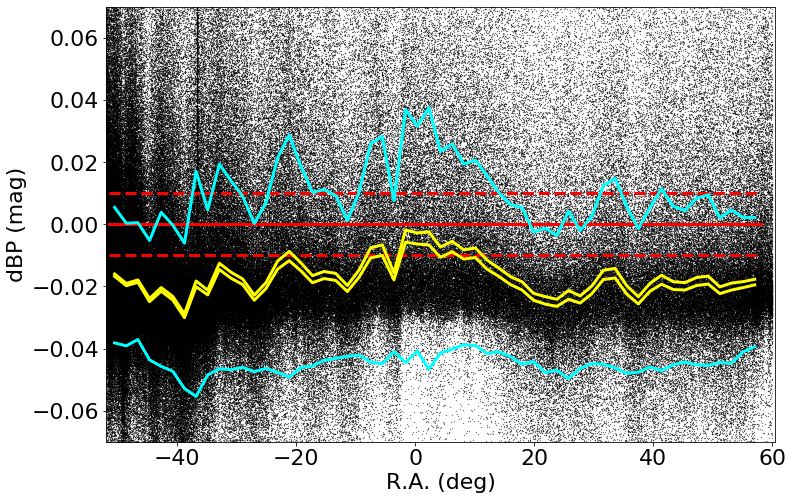

medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.018568038940429688 std.dev: 0.005622126127687351
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_RA_Hess.png


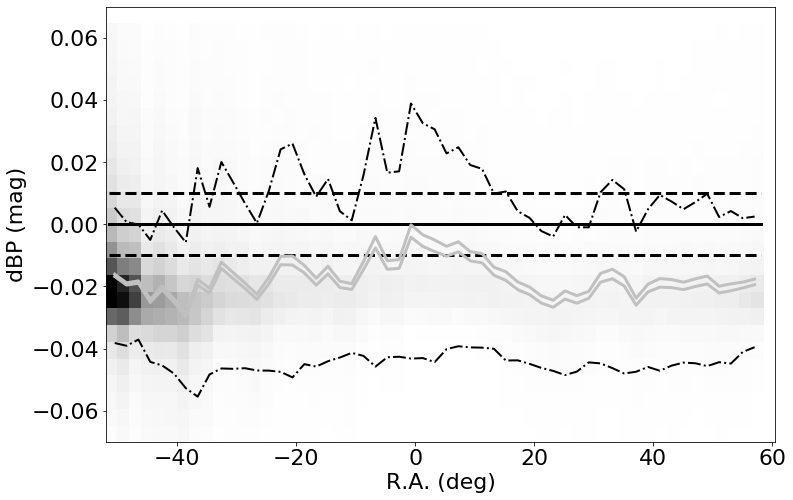

made plot testGaiaDR2vsEDR3_Gmag_dBP_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.017373085021972656 std.dev: 0.0007419926408256272
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Dec.png


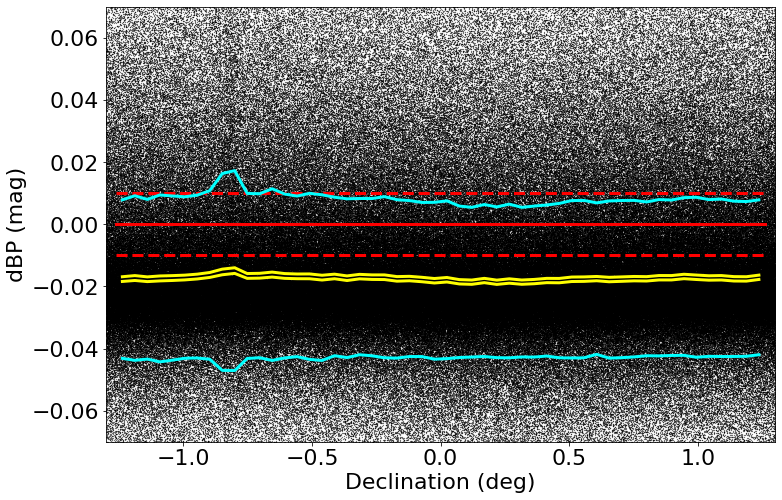

medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.017382144927978516 std.dev: 0.0007476148177848488
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Dec_Hess.png


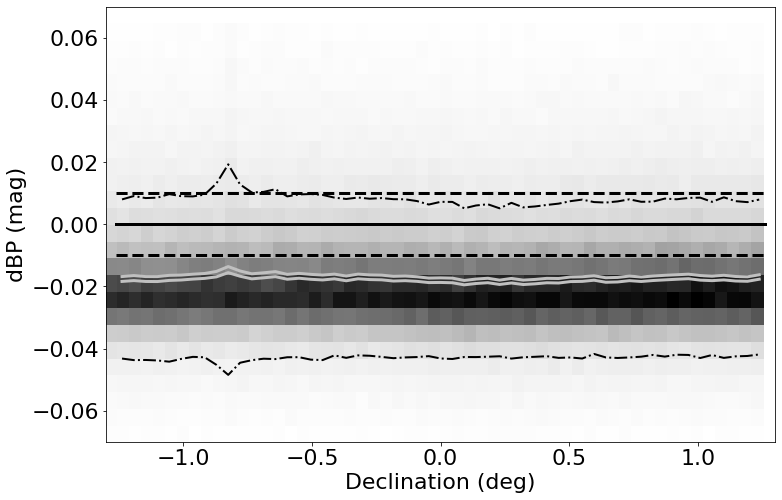

made plot testGaiaDR2vsEDR3_Gmag_dBP_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.019622802734375 std.dev: 0.012329715749032416
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_rmag.png


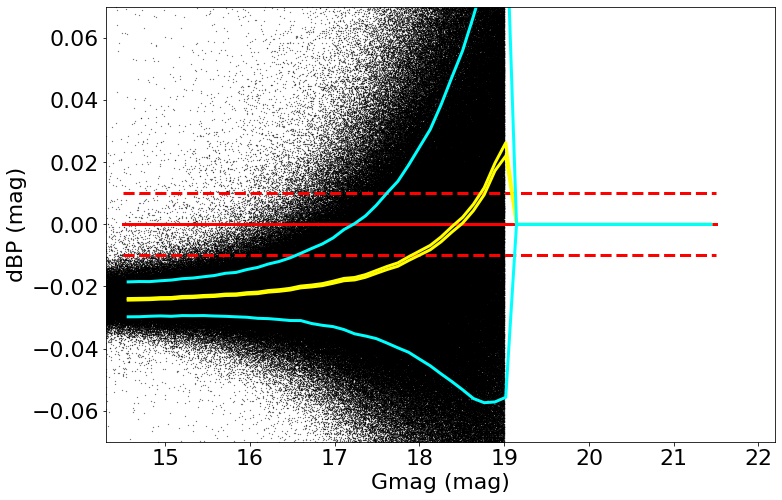

medianAll: -0.017365455627441406 std.dev.All: 0.02563384437561035
N= 923017 min= -0.29998016357421875 max= 0.29998207092285156
median: -0.019622802734375 std.dev: 0.012329715749032416
saved plot as: testGaiaDR2vsEDR3_Gmag_dBP_Gmag_mag_Hess.png


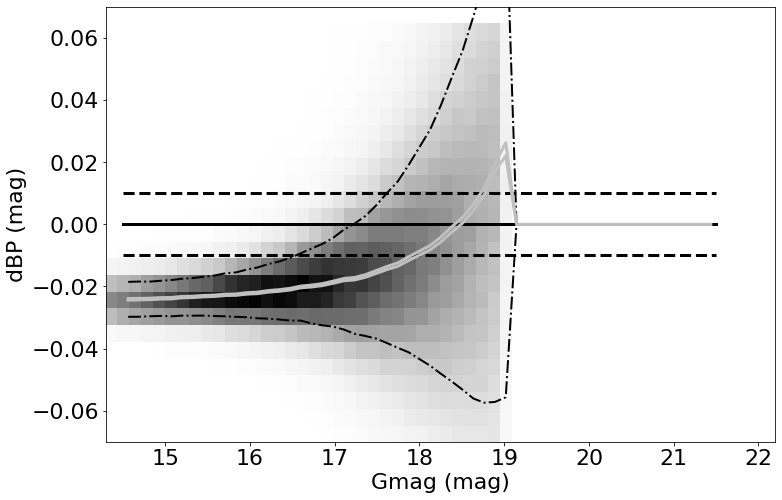

made plot testGaiaDR2vsEDR3_Gmag_dBP_Gmag_mag_Hess.png
------------------------------------------------------------------


In [69]:
keywords["Ystr"] = 'dBP'
doOneBand(gaiaB, keywords)

=========== WORKING ON: dRP ===================
 stats for RA binning medians:
medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.002480030059814453 std.dev: 0.010813725944436489
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_RA.png


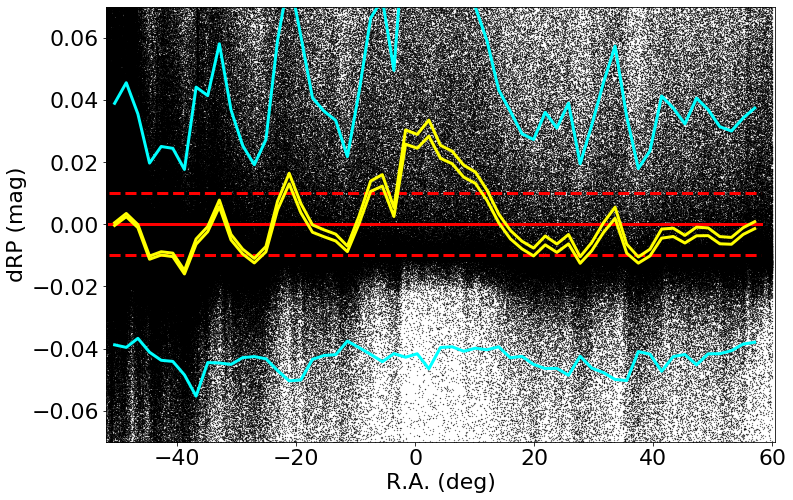

medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.0024232864379882812 std.dev: 0.010623535240297738
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_RA_Hess.png


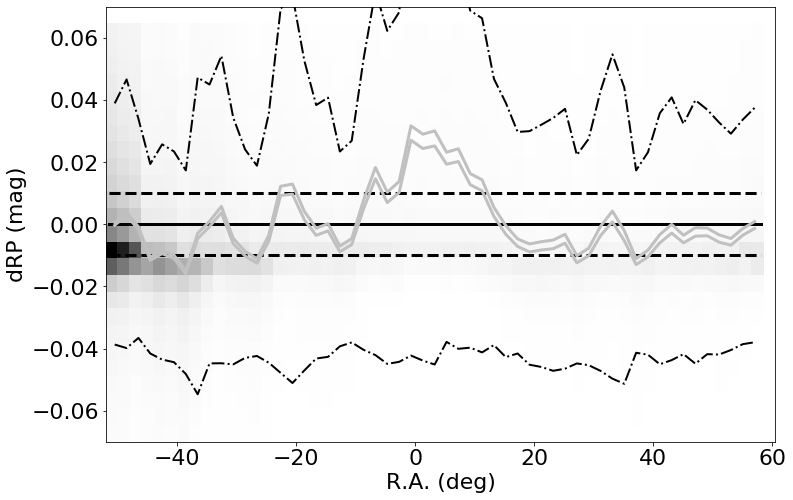

made plot testGaiaDR2vsEDR3_Gmag_dRP_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.0018467903137207031 std.dev: 0.0011647464452670567
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_Dec.png


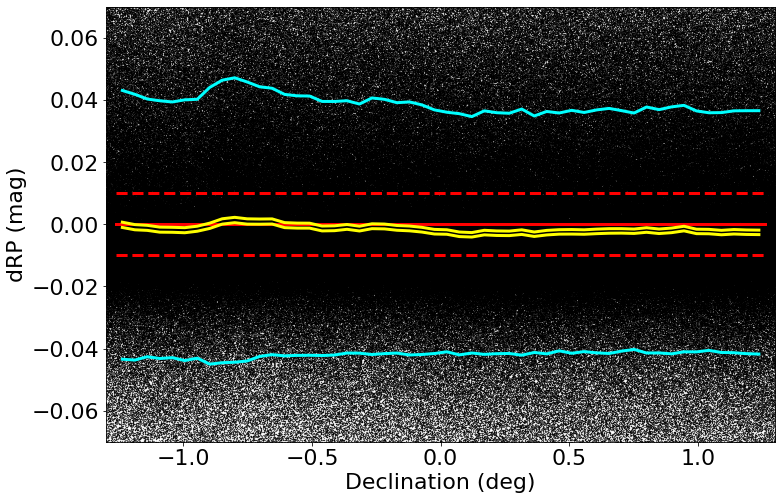

medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.0018253326416015625 std.dev: 0.0011734539587585713
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_Dec_Hess.png


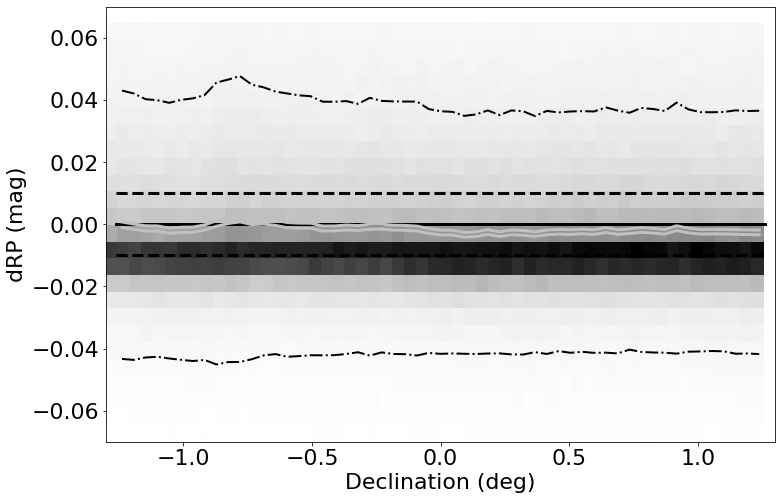

made plot testGaiaDR2vsEDR3_Gmag_dRP_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.00395965576171875 std.dev: 0.03391212254217094
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_rmag.png


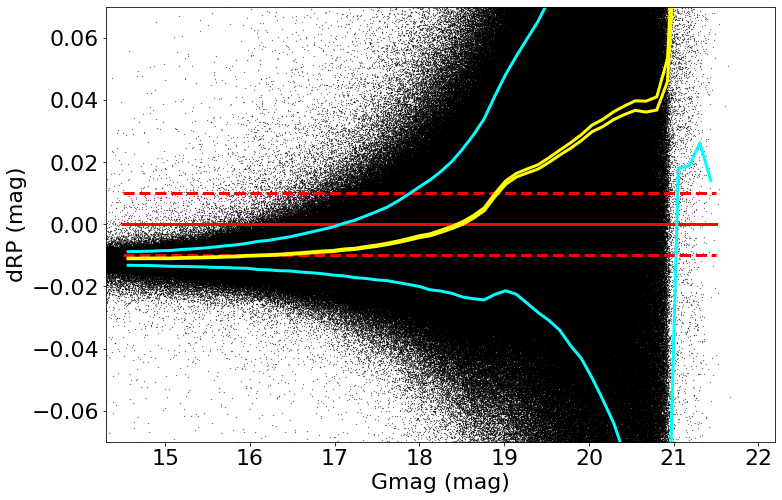

medianAll: -0.001628875732421875 std.dev.All: 0.04038846302032471
N= 2123707 min= -0.29998779296875 max= 0.29999542236328125
median: -0.00395965576171875 std.dev: 0.03391212254217094
saved plot as: testGaiaDR2vsEDR3_Gmag_dRP_Gmag_mag_Hess.png


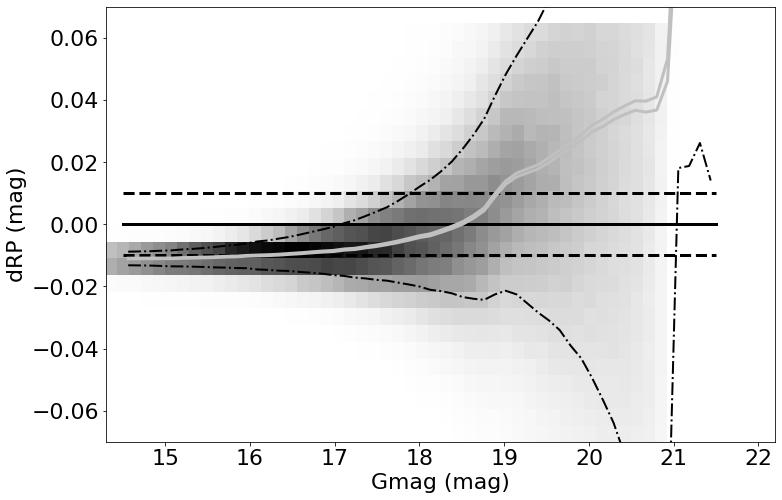

made plot testGaiaDR2vsEDR3_Gmag_dRP_Gmag_mag_Hess.png
------------------------------------------------------------------


In [70]:
keywords["Ystr"] = 'dRP'
doOneBand(gaiaOK4, keywords)

=========== WORKING ON: dBPRP ===================
 stats for RA binning medians:
medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.009089946746826172 std.dev: 0.003082444806405418
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_RA.png


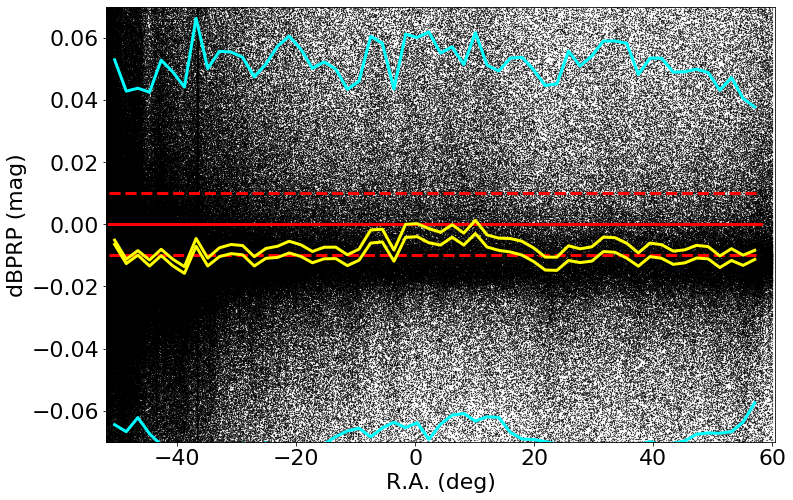

medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.008849143981933594 std.dev: 0.003071710697666057
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_RA_Hess.png


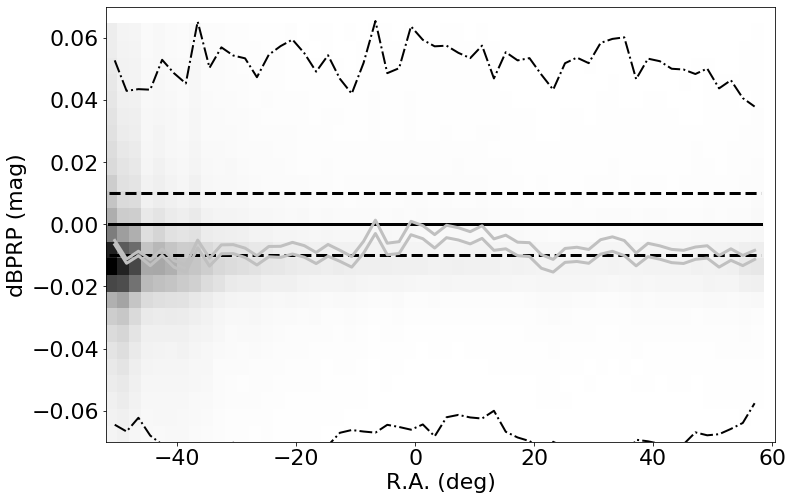

made plot testGaiaDR2vsEDR3_Gmag_dBPRP_RA_Hess.png
-----------
 stats for Dec binning medians:
medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.007215023040771484 std.dev: 0.0007787578767447044
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_Dec.png


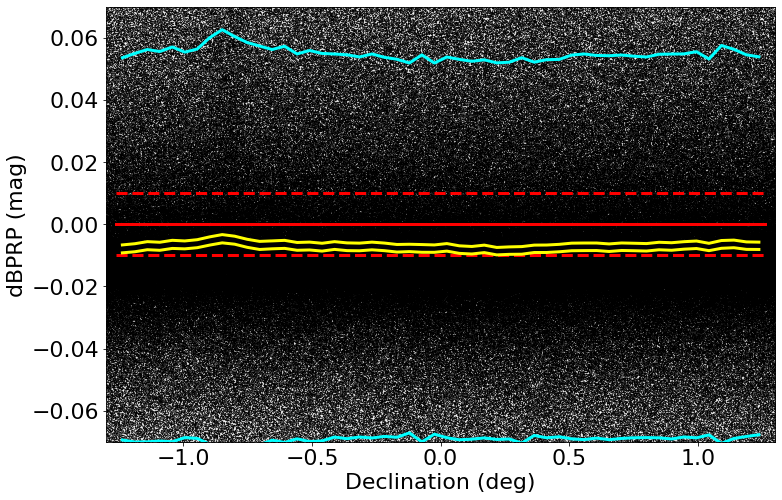

medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.007205963134765625 std.dev: 0.0007921786063594369
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_Dec_Hess.png


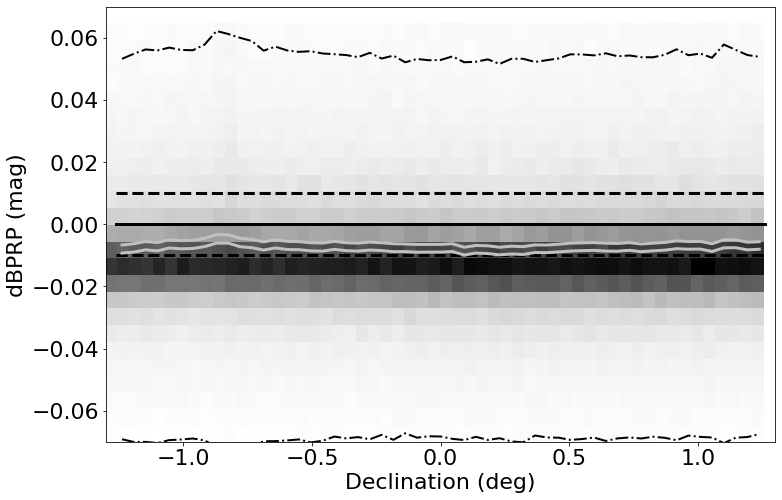

made plot testGaiaDR2vsEDR3_Gmag_dBPRP_Dec_Hess.png
-----------
 stats for SDSS r binning medians:
medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.0067005157470703125 std.dev: 0.01593893715083759
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_rmag.png


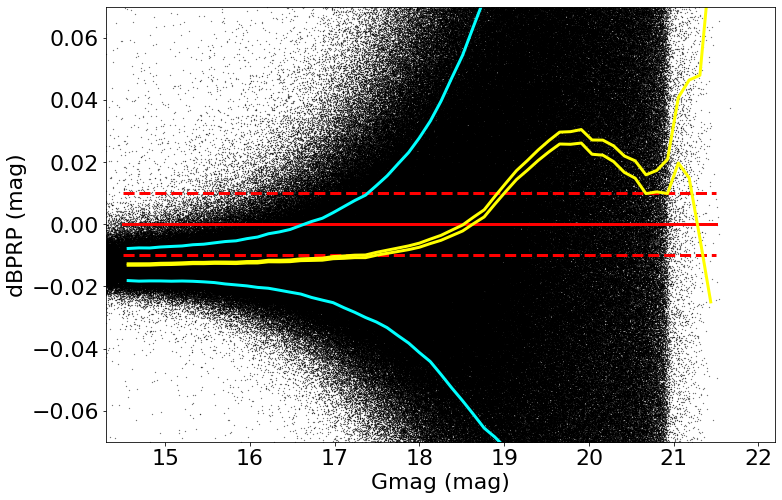

medianAll: -0.0071563720703125 std.dev.All: 0.06208260726928711
N= 1910119 min= -0.2999992370605469 max= 0.2999992370605469
median: -0.0067005157470703125 std.dev: 0.01593893715083759
saved plot as: testGaiaDR2vsEDR3_Gmag_dBPRP_Gmag_mag_Hess.png


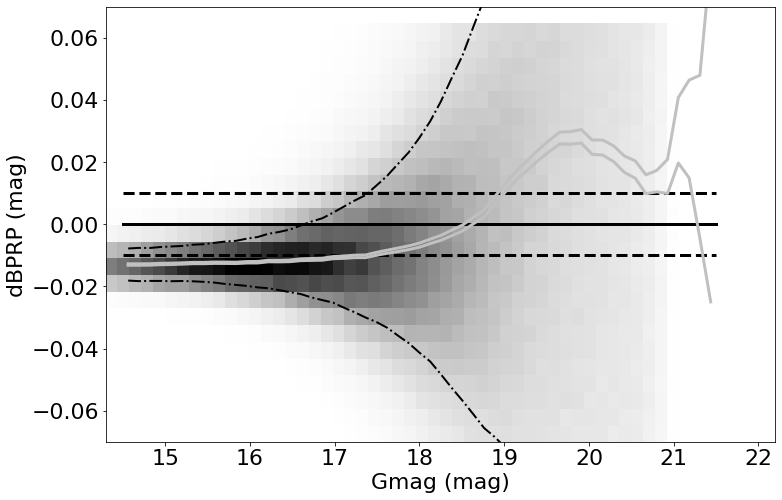

made plot testGaiaDR2vsEDR3_Gmag_dBPRP_Gmag_mag_Hess.png
------------------------------------------------------------------


In [71]:
gaiaOK4['dBPRP'] = gaiaOK4['dBP'] - gaiaOK4['dRP']
keywords["Ystr"] = 'dBPRP'
doOneBand(gaiaOK4, keywords)